# **IOC Extraction**

## Connect with google drive and imports libraries

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
import re
import json
import spacy
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

Mounted at /content/drive


## Load spaCy and DisilBERT NER model

In [ ]:
INPUT_FILE = "/content/drive/MyDrive/relevant_posts.csv"
OUTPUT_FILE = "/content/drive/MyDrive/extracted_iocs.json"

print("[INFO] Loading spaCy model...")
nlp_spacy = spacy.load("en_core_web_sm")

print("[INFO] Loading DistilBERT NER model...")
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


[INFO] Loading spaCy model...
[INFO] Loading DistilBERT NER model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


## IOC extraction using Regex

In [ ]:
IOC_PATTERNS = {
    "IP": r"\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b",
    "Domain": r"\b(?:[a-zA-Z0-9-]+\.)+[a-zA-Z]{2,}\b",
    "MD5": r"\b[a-fA-F0-9]{32}\b",
    "SHA1": r"\b[a-fA-F0-9]{40}\b",
    "SHA256": r"\b[a-fA-F0-9]{64}\b",
    "Email": r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b",
    "URL": r"https?://[^\s/$.?#].[^\s]*"
}


def extract_regex_iocs(text):
    found = {}
    for key, pattern in IOC_PATTERNS.items():
        matches = re.findall(pattern, text)
        if matches:
            found[key] = sorted(set(matches))
    return found

def extract_spacy_entities(text):
    doc = nlp_spacy(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

def extract_bert_entities(text):
    results = ner_pipeline(text)
    return [(ent['word'], ent['entity_group']) for ent in results]


## Load relevant posts CSV

In [ ]:
df = pd.read_csv(INPUT_FILE)

text_column = None
for col in ["clean_text", "post", "text"]:
    if col in df.columns:
        text_column = col
        break
if not text_column:
    raise ValueError("No suitable text column found in CSV. Expected 'clean_text', 'post', or 'text'.")

print(f"[INFO] Found text column: {text_column}")
print(f"[INFO] Total relevant posts: {len(df)}")


[INFO] Found text column: clean_text
[INFO] Total relevant posts: 159


## Extract IOCs for each post

In [ ]:
output_data = []

for idx, row in df.iterrows():
    text = str(row[text_column])

    regex_iocs = extract_regex_iocs(text)
    spacy_entities = extract_spacy_entities(text)
    bert_entities = extract_bert_entities(text)

    output_data.append({
        "post_id": row.get("id", idx),
        "post_text": text,
        "regex_iocs": regex_iocs,
        "spacy_entities": spacy_entities,
        "bert_entities": bert_entities
    })

print(f"[INFO] Extraction complete for {len(output_data)} posts.")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[INFO] Extraction complete for 159 posts.


## Save to JSON in google drive

In [ ]:
with open(OUTPUT_FILE, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"[INFO] IOC extraction saved to: {OUTPUT_FILE}")

[INFO] IOC extraction saved to: /content/drive/MyDrive/extracted_iocs.json


## Visualize Proportion of IOC Types

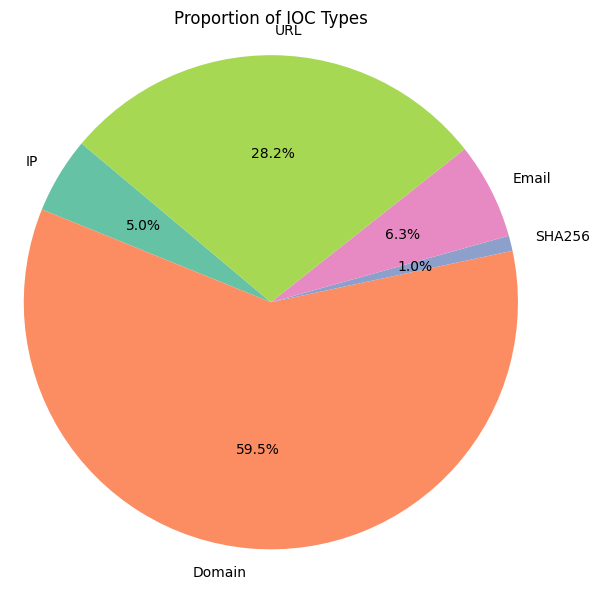

In [ ]:
import json
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

with open(OUTPUT_FILE, 'r') as f:
    data = json.load(f)

ioc_counter = Counter()
for post in data:
    regex_iocs = post.get('regex_iocs', {})
    for ioc_type, values in regex_iocs.items():
        ioc_counter[ioc_type] += len(values)


labels = list(ioc_counter.keys())
sizes = list(ioc_counter.values())
colors = sns.color_palette('Set2', len(labels))

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Proportion of IOC Types')
plt.axis('equal')
plt.tight_layout()
plt.show()